<a href="https://colab.research.google.com/github/shiernee/AI-Driven_Fetal_Monitoring_Model_to_Predict_FGR/blob/main/Milestone2_AI_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import joblib

In [ ]:
!pip install --upgrade matplotlib -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 50.1 MB/s eta 0:00:00


In [ ]:
# %matplotlib inline
# %matplotlib notebook
import pandas as pd
import numpy as np
from sklearn.metrics import balanced_accuracy_score, roc_auc_score, f1_score, roc_curve, precision_score, recall_score, accuracy_score
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.model_selection import StratifiedGroupKFold
from imblearn.over_sampling import RandomOverSampler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
import matplotlib.pyplot as plt

In [ ]:
def convert_feature_to_label(df, col):
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    return df

def convert_feature_to_one_hot(df, col):
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    oh = OneHotEncoder(handle_unknown='ignore')
    df_oh = pd.DataFrame(oh.fit_transform(df[[col]]).toarray())
    df = df.join(df_oh)

    rename_dict = {}

    for i, name in zip(df_oh.columns, le.classes_):
        rename_dict[i] = str(col) + '_' + str(name)

    df = df.rename(columns=rename_dict)
    df.drop(col, axis = 1, inplace = True)

    return df

def scale_feature(col, method='std'):
    if method == 'std':
        std = np.std(col)
        mean = np.mean(col)
        return (col - mean) / std, mean, std
    elif method =='minmax':
        min = np.min(col)
        max = np.max(col)
        return (col - min) / max

def calc_metrics(y_true, y_pred, metrics=[]):
    out = []
    #y_pred = y_pred >= 0.8357
    for met in metrics:
        if not met == roc_auc_score:
            out.append(met(y_true, y_pred.argmax(1)))
        else:
            out.append(met(y_true, np.max(y_pred, 1)))

    return out

def calc_class_weights(df, target='sga', type='log'):
    if type == 'log':
        valid_class = df[target].value_counts().sort_index().values
        # 1 / (1+ln(x))
        class_weights = 1./np.log1p(valid_class)
        # Normalize class_weights and multiply with number of classes
        class_weights = class_weights / class_weights.sum() * 2

    elif type == 'normal':
        classes = df[target].value_counts().sort_index().values
        class_weights = classes/df.shape[0]
        class_weights = 1 - class_weights
        class_weights = class_weights / class_weights.sum() * 2

    else:
        class_weights = None

    return class_weights

def ohe(df):
    # OHE for categorical data
    for col in ['hypertension', 'diabetes']:
        df = convert_feature_to_one_hot(df, col)
    for col in ['gender', 'smoking']:
        df = convert_feature_to_label(df, col)

    # OHE for ordinal data
    df = df.replace({'oligohydramnios' : 0, 'normal' : 1, 'polyhydramnios' : 2})
    return df

def ohe_tri3(df):
    # OHE for categorical data
    for col in ['presentation', 'placenta_site', 'hypertension', 'diabetes']:
        df = convert_feature_to_one_hot(df, col)
    for col in ['gender', 'smoking']:
        df = convert_feature_to_label(df, col)

    # OHE for ordinal data
    df = df.replace({'oligohydramnios' : 0, 'normal' : 1, 'polyhydramnios' : 2})
    return df

def data_impute(df):
    # Iterative data imputation
    imputer = IterativeImputer(random_state = 123)
    imputed = imputer.fit_transform(df)
    return pd.DataFrame(imputed, columns = df.columns)

def sgkf(df, label = 'sga'):
    sgkf = StratifiedGroupKFold(shuffle=True, random_state=123, n_splits = 5)

    df['fold'] = -1

    for fold_num, (_, val_idx) in enumerate(sgkf.split(df, df[label], groups=df.id)):
        df.loc[val_idx, 'fold'] = fold_num

    return df.drop('id', axis=1)

# Tri2

In [ ]:
def rf(df, label = 'sga'):
    selected_rfc = 0
    training_cols = 0

    train_cols = df.columns
    train_cols = train_cols.drop([label, 'fold', 'cur_sga', 'sga'])
    oof_acc = []
    oof_roc_auc = []
    oof_f1 = []
    oof_prec = []
    oof_rec = []
    oof_thresh = []
    temp = None

    class_weights = calc_class_weights(df, target= label, type='normal')



    for fold in range(5):

      ros = RandomOverSampler(random_state = 317)
      rfc = RandomForestClassifier(n_estimators = 56, criterion = 'log_loss', max_depth = 3, min_samples_split = 0.27, min_samples_leaf = 8, bootstrap = False, ccp_alpha = 0.05, max_features = None, min_impurity_decrease = 0.0332, random_state = 123)
      train_df = df[df['fold'] != fold].reset_index(drop=True)
      train_X, train_Y = ros.fit_resample(train_df[train_cols], train_df[label])
      # train_X, train_Y = train_df[train_cols], train_df[label]
      val_df = df[df['fold'] == fold].reset_index(drop=True)
      tmp = val_df[['sga', 'cur_sga', label]]
      val_df = val_df.drop(['sga', 'cur_sga'], axis=1)
      sample_weights = [class_weights[int(x)] for x in train_Y]

      rfc.fit(train_X, train_Y)

      out = rfc.predict_proba(val_df[train_cols])
      acc, roc_auc, f1, prec, rec = calc_metrics(val_df[label], out, metrics=[balanced_accuracy_score, roc_auc_score, f1_score, precision_score, recall_score])
      out2 = rfc.predict_proba(val_df[train_cols])
      out2 = out2.argmax(1)
      cur_sga = tmp['sga']
      out2 = np.logical_xor(out2, cur_sga.to_numpy())

      oof_acc.append(acc)
      oof_roc_auc.append(roc_auc)
      oof_f1.append(f1)
      oof_prec.append(prec)
      oof_rec.append(rec)
      joblib.dump(rfc, f'tri2_rfc_{fold}.joblib')
      joblib.dump(train_cols, 'training_cols.joblib')

      print("********************")
      print(f"Fold: {fold}")
      print(f"Balanced Accuracy: {acc:.4f}")
      print(f"ROC AUC: {roc_auc:.4f}")
      print(f"F1: {f1:.4f}")
      print(f"Precision: {prec:.4f}")
      print(f"Recall: {rec:.4f}")

    print("********************")
    print(f'OOF Balanced Accuracy: {np.mean(oof_acc):.4f} (±{np.std(oof_acc):.4f})')
    print(f'OOF ROC AUC Score: {np.mean(oof_roc_auc):.4f} (±{np.std(oof_roc_auc):.4f})')
    print(f'OOF F1 Score: {np.mean(oof_f1):.4f} (±{np.std(oof_f1):.4f})')
    print(f'OOF Prec Score: {np.mean(oof_prec):.4f} (±{np.std(oof_prec):.4f})')
    print(f'OOF Recall Score: {np.mean(oof_rec):.4f} (±{np.std(oof_rec):.4f})')


    return temp


tri2 = pd.read_csv('/content/cyf_clean_tri2.csv')
# tri2 = pd.read_csv('/content/drive/MyDrive/SGA/cyf_clean_tri2.csv')
# tri2.drop(['sga', 'lbw', 'cur_sga'], axis = 1, inplace = True)
continuous_col = ['ac', 'bpd', 'cm', 'efw_centile', 'efw', 'fl', 'ga', 'hc', 'hl', 'tcd', 'mother_age_at_start_date', 'mother_height', 'mother_weight']
ori_tri2 = tri2.copy()
for c in continuous_col:
  tri2[c], _, _ = scale_feature(tri2[c], method='std')

tri2 = tri2[['ac', 'bpd', 'efw_centile', 'efw', 'fl', 'ga', 'hc', 'mother_age_at_start_date', 'mother_height', 'mother_weight', 'smoking', 'gender', 'hypertension', 'diabetes', 'status_change', 'id', 'sga', 'cur_sga']]
tri2 = ohe(tri2)
tri2 = data_impute(tri2)
tri2 = sgkf(tri2, label = 'status_change')
rf(tri2, label = 'status_change')
# joblib.dump(rf, 'tri2_rf.joblib')

********************
Fold: 0
Balanced Accuracy: 0.8947
ROC AUC: 0.8992
F1: 0.8824
Precision: 1.0000
Recall: 0.7895
********************
Fold: 1
Balanced Accuracy: 0.8937
ROC AUC: 0.8937
F1: 0.8000
Precision: 0.7778
Recall: 0.8235
********************
Fold: 2
Balanced Accuracy: 0.7164
ROC AUC: 0.6250
F1: 0.3889
Precision: 0.2917
Recall: 0.5833
********************
Fold: 3
Balanced Accuracy: 0.7378
ROC AUC: 0.5450
F1: 0.6222
Precision: 0.7778
Recall: 0.5185
********************
Fold: 4
Balanced Accuracy: 0.7493
ROC AUC: 0.6190
F1: 0.4348
Precision: 0.3125
Recall: 0.7143
********************
OOF Balanced Accuracy: 0.7984 (±0.0790)
OOF ROC AUC Score: 0.7164 (±0.1497)
OOF F1 Score: 0.6256 (±0.1943)
OOF Prec Score: 0.6319 (±0.2814)
OOF Recall Score: 0.6858 (±0.1175)


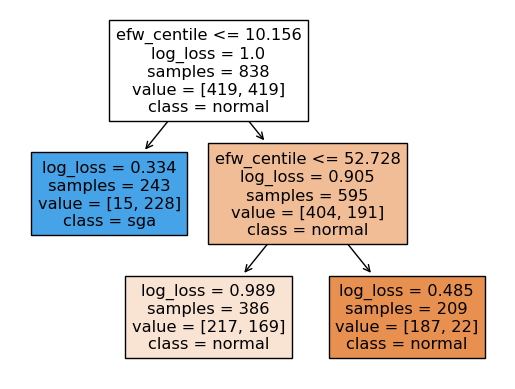

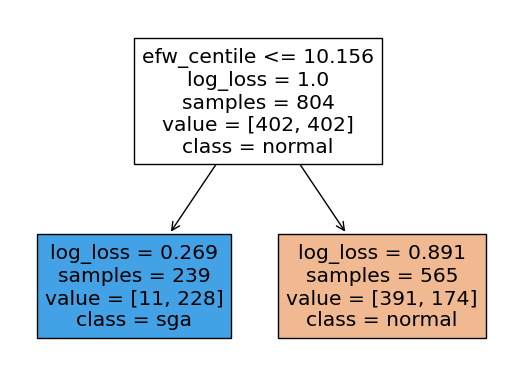

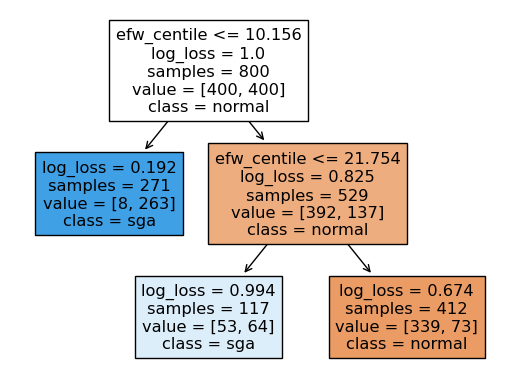

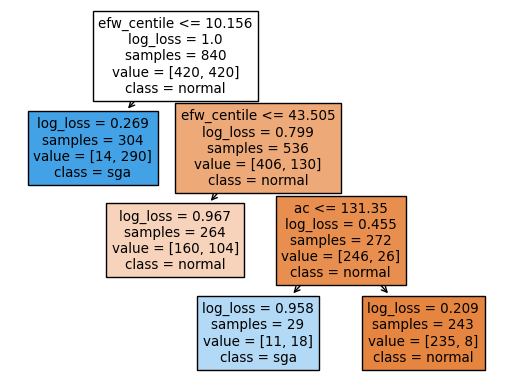

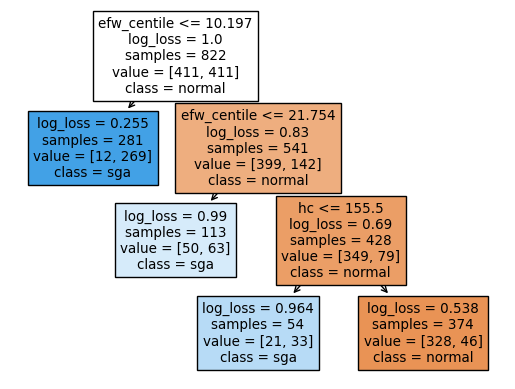

In [ ]:
## COPY HERE ###
from sklearn import tree
training_cols = joblib.load("/content/training_cols.joblib")

for i in range(5):
  selected_rfc = joblib.load(f"/content/tri2_rfc_{i}.joblib")
  tree.plot_tree(selected_rfc.estimators_[0],
                  feature_names = training_cols.tolist(),
                  class_names=["normal", "sga"], filled=True, precision=3)
  plt.show()